# LET'S GET READY TO RUMBLE!!!

In [63]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils

In [64]:
# Batch size
batch_size = 64
# number of epochs
epochs = 30
# learning rate
alpha = 0.0002
# beta1
beta1 = 0.5
# beta2
beta2 = 0.999
# Z vector size
nz = 100

# Channels, H, W
img_shape = (1, 28, 28)
# Take advantage of the computer's GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [65]:
os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor(), tvtransforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)

First, we need to create our loss functions. From the first paper, the discriminator loss from Algorithm 1, which we want to maximize, is:

$\mathcal{L}_d = \frac{1}{m}\sum_{i=1}^m\left(\log(D(x^{(i)})) + \log(1 - D(G(z^{(i)})))\right)$.

The generator loss, which we want to minimize, is

$\mathcal{L}_g = \frac{1}{m}\sum_{i=1}^m\log(1 - D(G(z^{(i)})))$.

Unfortunately, this generator loss function can be troublesome in practice. An alternative the authors suggest is

$\mathcal{L}_g = \frac{1}{m}\sum_{i=1}^m\log(D(G(z^{(i)})))$.

This function then needs to be maximized.

In [66]:
# Some handy functions:
# torch.mean()
# torch.log()

def discriminator_loss(D_of_real, D_of_fake):
    # TODO: implement loss for discriminator
    # What sign should be applied in order to maximize it?
    # unsummed = torch.log(D_of_real) + log(1-D_of_fake)
    return -torch.mean(torch.log(D_of_real) + torch.log(1-D_of_fake))

def generator_loss(D_of_fake):
    # TODO: implment loss for generator
    # What sign should be applied in order to maximize or minimize it?
    return -torch.mean(torch.log(D_of_fake))

## IN THE G CORNER...
A simple generator can be constructed from sequential, fully connected layers.

In [67]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Calculate the size of the final output vector
        flattened_output_size = 1
        for dim in img_shape:
            flattened_output_size *= dim

        # A sequence of layers that are applied to an input
        self.model = nn.Sequential(
            # Layer 1
            # TODO: what should the first network input size be?
            nn.Linear(nz, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            # Fully connected layer with input size 128, output size 256
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            # TODO: add a fully connected layer with input size 256 and output 512
            # TODO: add batchnorm
            # TODO: add activation
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            

            # Layer 4
            # TODO: add a fully connected layer with input size 512 and output 1024
            # TODO: add batchnorm
            # TODO: add activation
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # Final Layer
            # Map to desired image size
            nn.Linear(1024, flattened_output_size),
            nn.Tanh()
        )
        
    def forward(self, z):
        # img is flat and needs to be reshaped
        img = self.model(z)
        # reshape to (batch_size, channels, H, W)
        img = img.view(img.size(0), *img_shape)
        return img


class ConvGenerator(nn.Module):

    def __init__(self):
        super(ConvGenerator, self).__init__()

        self.activation = nn.LeakyReLU(0.2, inplace=True)

        self.fc_1 = nn.Linear(nz, 128)
        self.bn_1 = nn.BatchNorm1d(128)

        self.fc_2 = nn.Linear(128, 784)
        self.bn_2 = nn.BatchNorm1d(784)

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(64)
 
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 1, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.activation(x)
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.bn_3(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn_4(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x





            


## AND IN THE D CORNER...
The descriminator can also be constructed from sequential linear layers. We need to down scale the input to a single value for classification.

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),

            # TODO: add fully connected layer with input size 512 and output size 256
            # TODO: add batch norm
            # TODO: add activation
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        # Flatten the image and feed into model
        return self.model(img.view(img.size(0), -1))


class ConvDiscriminator(nn.Module):

    def __init__(self):
        super(ConvDiscriminator, self).__init__()
        self.activation = nn.LeakyReLU(0.2, inplace=True)


        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 1, 1)
        self.bn_5  = nn.BatchNorm2d(64)

        self.lin_out = nn.Linear(64, 1)
        
    def forward(self, img):
        x = self.conv1(img)
        x = self.bn_3(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn_4(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = x.view(-1, 64)
        return torch.sigmoid(self.lin_out(x))
        
      
        

In [69]:
# Create generator and move it to the GPU, if available
gen_model = ConvGenerator()
print(gen_model)
gen_model = gen_model.to(device)
# Create discriminator and move it to the GPU, if available
disc_model = ConvDiscriminator().to(device)
print(disc_model)

# Initialize optimizers
gen_opt = torch.optim.Adam(gen_model.parameters(), lr=alpha, betas=(beta1, beta2))
disc_opt = torch.optim.Adam(disc_model.parameters(), lr=alpha, betas=(beta1, beta2))

ConvGenerator(
  (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc_1): Linear(in_features=100, out_features=128, bias=True)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=128, out_features=784, bias=True)
  (bn_2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (tanh): Tanh()
)
ConvDiscriminator(
  (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1,

# FIGHT!

In [70]:
g_losses = []
d_losses = []
fixed_img_list = []
# A fixed set of z vectors to periodically generate images from
fixed_z_vecs = torch.randn(64, nz, device=device)
iters = 0
from sys import stdout
epochs = 30
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader, 0):
        # Move the images to the GPU memory, if possible
        real_imgs = real_imgs.to(device)
        
        # Run D on real images
        disc_model.zero_grad()
        #
        # TODO: compute D(x)
        #
        #print(real_imgs.shape, 'real images')
        D_real = disc_model(real_imgs)
               
        # Run D on generated fake images
        z_sample = torch.randn(batch_size, nz, device=device)
        #
        # TODO: compute G(z)
        #
        #fake_imgs = conv_gen_model(z_sample)
        fake_imgs = gen_model(z_sample)

        D_fake = disc_model(fake_imgs.detach())
        # Compute D's loss and update D's weights
        disc_err = discriminator_loss(D_real, D_fake)
        disc_err.backward()
        disc_opt.step()
        
        # Update G by maximizing log(D(G(z)))
        gen_model.zero_grad()
        D_fake = disc_model(fake_imgs)
        gen_err = generator_loss(D_fake)
        gen_err.backward()
        gen_opt.step()
        
        if i % 100 == 0:
            print("[{}/{}][{}/{}]".format(epoch+1, epochs, i, len(dataloader)), end='\r')
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            # Periodically capture generated samples using the same z vectors
            with torch.no_grad():
                fake = gen_model(fixed_z_vecs).detach().cpu()
            fixed_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        g_losses.append(gen_err.item())
        d_losses.append(disc_err.item())
        iters += 1

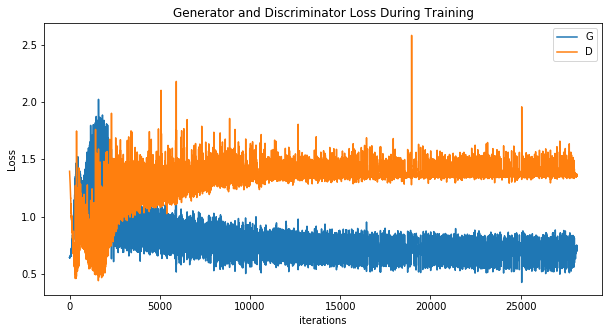

[0.6410207152366638, 0.6398704051971436, 0.6447052955627441, 0.6438296437263489, 0.6451043486595154, 0.6480664610862732, 0.642352819442749, 0.64182448387146, 0.6433746218681335, 0.6441347002983093, 0.6418934464454651, 0.640072762966156, 0.642255425453186, 0.6400110721588135, 0.640817403793335, 0.6409404873847961, 0.6435157656669617, 0.6419140696525574, 0.642295777797699, 0.6450864672660828, 0.6458528637886047, 0.6458985805511475, 0.6454012393951416, 0.6439906358718872, 0.646559476852417, 0.648645281791687, 0.6466957926750183, 0.6473230123519897, 0.6429693102836609, 0.6497616767883301, 0.6487826108932495, 0.6491758823394775, 0.6466268301010132, 0.6491603851318359, 0.6495646238327026, 0.6502001881599426, 0.6501556634902954, 0.6500016450881958, 0.6528830528259277, 0.6509227752685547, 0.6515229344367981, 0.6489489674568176, 0.6537104845046997, 0.6553632616996765, 0.6487398743629456, 0.6579916477203369, 0.6545853614807129, 0.6549753546714783, 0.655092179775238, 0.6577677726745605, 0.6562342

In [71]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print(g_losses)

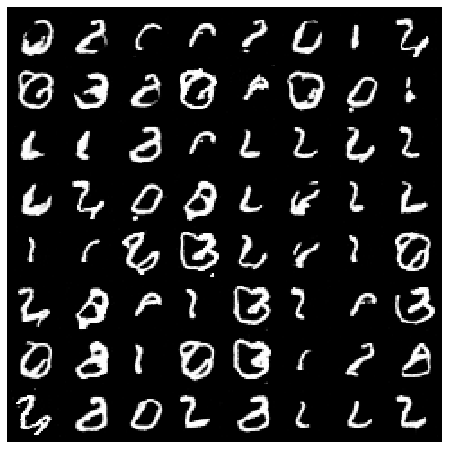

In [73]:
# Create slide show from fixed z images
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)]
    for i in fixed_img_list
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Questions
1. Does making the generator more complex (adding layers) improve the generated images?
I didn't experiment with adding more fully connected layers but adding convolutional layers definitely reduces the noise present in the images. Adding conv. layers to the generator without adding them to the discriminator seemed to let the generator "overpower" the discriminator easily. This resulted in generated images with some high frequency noise even after 30 epochs.

2. Does making the discriminator more complex or smarter force the generator to improve as well? Yes, definitely.
3. Can you get the original generator loss function (i.e. log(1 - D(G(z)))) to work? Perhaps transition to it after some number of epochs. I didn't do this but I did do the next one.

4. Bonus: Can you refactor the models to use convolution instead of fully connected layers? Yes.

## Links
* [Link](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html): pytorch tutorial for DCGAN using a face dataset
* [Link](https://junyanz.github.io/CycleGAN/): the CycleGAN website